In [1]:
import pandas as pd
import os
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc

Pre-processing:

https://www.kaggle.com/datasets/vijeetnigam26/expedia-hotel

In [2]:
f = open(os.getcwd() + "/train.csv", "r")
df = pd.read_csv(f)

In [3]:
# We will be stratifying on our target variable - booking_bool:
df['booking_bool'].value_counts()

0    9640937
1     276593
Name: booking_bool, dtype: int64

Dealing with missing values; dropping all rows that do not contain our target variable - comp1_rate:

Target Variable:
    comp1_rate
        - does Expedia offer lower rates than its competitors
        
Explanatory Variables:
    srch_saturday_night_bool
             - +1 if the stay includes a Saturday night, starts from Thursday with a length of stay is less than or equal to 4 nights (i.e. weekend); otherwise 0
         
    prop_location_score1:
        - A (first) score outlining the desirability of a hotel’s location
        
    prop_brand_bool:
        - +1 if the hotel is part of a major hotel chain; 0 if it is an independent hotel   
        
        
    
    

Transforming the "comp1_rate" column to be a binary classificaiton of whether Expedia offers a better price or not:

In [39]:
def adjustRate(row):
    if row["comp1_rate"] == 1.0:
        return 1
    else:
        return 0

In [40]:
booked_df = df[df["booking_bool"] == 1]

In [41]:
booked_df["booking_bool"].value_counts()

1    276593
Name: booking_bool, dtype: int64

In [42]:
not_booked_sample = df[df["booking_bool"] == 0].sample(n=len(booked_df), random_state = 42) 

In [47]:
not_booked_sample["booking_bool"].value_counts()

0    276593
Name: booking_bool, dtype: int64

In [55]:
stratified = pd.concat([booked_df, not_booked_sample])

In [57]:
stratified["booking_bool"].value_counts()

0    276593
1    276593
Name: booking_bool, dtype: int64

In [58]:
# Separate the features and target variable
X = stratified.drop('booking_bool', axis=1)
y = stratified['booking_bool']

In [64]:
# Split the data into training and test sets
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
train = X1.copy()
train["booking_bool"] = y1

In [86]:
test = X2.copy()
test["booking_bool"] = y2

Creating a new column with binary classification as to whether a location is considered "good":

In [87]:
train_location_median = train["prop_location_score1"].median()
test_location_median = test["prop_location_score1"].median()

In [88]:
def aboveOrBelowTrain(row):
    if row["prop_location_score1"] >= train_location_median:
        return 1
    else:
        return 0

In [89]:
def aboveOrBelowTest(row):
    if row["prop_location_score1"] >= test_location_median:
        return 1
    else:
        return 0

In [90]:
train["isGoodLocation"] = train.apply(aboveOrBelowTrain, axis=1)

In [91]:
test["isGoodLocation"] = test.apply(aboveOrBelowTest, axis=1)

In [92]:
train['booking_bool'].value_counts()

1    221290
0    221258
Name: booking_bool, dtype: int64

Model Building - Logistic Regression:

In [101]:
predictors = ["srch_saturday_night_bool", "prop_brand_bool", "isGoodLocation"]

Crossvalidation:
* cv = number of folds
* Cs = list of floats or int with the inverse of regularization strength. smaller values specify stronger regularization
* scoring =  A string or a scorer (see sklearn.metrics). The default scoring option used is ‘accuracy’.

In [102]:
print("n_samples: {0} is greater than n_features {1}".format(train.shape[0], train.shape[1]))

print("Because n_samples >> n_features, we will choose - for now - the newton-cholesky solver:")

n_samples: 442548 is greater than n_features 55
Because n_samples >> n_features, we will choose - for now - the newton-cholesky solver:


In [103]:
X_train = train[predictors]
y_train = train["booking_bool"]
X_test = train[predictors]
y_test = train["booking_bool"]

In [104]:
X_train

,srch_saturday_night_bool,prop_brand_bool,isGoodLocation
9365237,0,0,1
5450388,1,0,0
6609534,1,0,0
3368420,0,1,1
2530622,1,1,0
...,...,...,...
3958306,0,0,1
9288593,1,1,0
9455101,0,0,1
4727911,1,1,0


In [105]:
from sklearn.linear_model import LogisticRegressionCV

# inverse regularization strength:
listC = list(np.power(10.0, np.arange(-4, 4)))
model_cv = LogisticRegressionCV(cv=10,Cs=listC, solver="newton-cg")
clf = model_cv.fit(X_train, y_train)

/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/

In [106]:
# accuracy for each fold
clf.scores_[1]

array([[0.5141114 , 0.5141114 , 0.5141114 , 0.5141114 , 0.5141114 ,
        0.5141114 , 0.5141114 , 0.5141114 ],
       [0.51930855, 0.51930855, 0.51930855, 0.51930855, 0.51930855,
        0.51930855, 0.51930855, 0.51930855],
       [0.51607728, 0.51607728, 0.51607728, 0.51607728, 0.51607728,
        0.51607728, 0.51607728, 0.51607728],
       [0.5135239 , 0.5135239 , 0.5135239 , 0.5135239 , 0.5135239 ,
        0.5135239 , 0.5135239 , 0.5135239 ],
       [0.51528641, 0.51528641, 0.51528641, 0.51528641, 0.51528641,
        0.51528641, 0.51528641, 0.51528641],
       [0.51485708, 0.51485708, 0.51485708, 0.51485708, 0.51485708,
        0.51485708, 0.51485708, 0.51485708],
       [0.51320755, 0.51320755, 0.51320755, 0.51320755, 0.51320755,
        0.51320755, 0.51320755, 0.51320755],
       [0.51686815, 0.51686815, 0.51686815, 0.51686815, 0.51686815,
        0.51686815, 0.51686815, 0.51686815],
       [0.51321914, 0.51321914, 0.51321914, 0.51321914, 0.51321914,
        0.51321914, 0.513219

In [110]:
print("The mean accuracy across all folds and regularization values is:", clf.scores_[1].mean())

The mean accuracy across all folds and regularization values is: 0.5155079241643425


In [116]:
y_pred = model_cv.predict(y_test)

TypeError: predict() takes 2 positional arguments but 3 were given

In [113]:
# model_cv.score(X_train,y_train)
cnf_cv_matrix = metrics.confusion_matrix(y_test,)

print("Cross-validation LogReg confusion matrix:")
cnf_cv_matrix

NameError: name 'y_cv_pred' is not defined

In [301]:
# check which value of C was selected
print(model_cv.C_) 
# Array of C that maps to the best scores across every class. If refit is set to False, then for each class, the best C is the average of the C’s that correspond to the best scores for each fold. C_ is of shape(n_classes,) when the problem is binary.

[0.0001]


In [302]:
model_cv.score(X_train,y_train)

0.973876720171328

RANDOM FOREST:

HYPERTUNING:

In [303]:
# For, logistic regression the main hyperparameter to tune is the **regularization strength** (also $\lambda$ or C).

print("The model selected a regularization strength 'C' of: ")
print(model_cv.C_)

The model selected a regularization strength 'C' of: 
[0.0001]


Doing our own testing:

In [304]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline to scale the data and fit a logistic regression model
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Define the parameter grid to search over
param_grid = {
#      L1 or L2 regularization:
    'logreg__penalty': ['l1', 'l2'],
#     C-values to search over:
    'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
#     searching which solver will be best:
    'logreg__solver': ['liblinear', 'saga', 'newton-cg']
}

# Create a GridSearchCV object and fit it to the data
grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_



/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports on

In [305]:
print("Best hyperparameters: ", best_params)
print("Best score: ", best_score)

Best hyperparameters:  {'logreg__C': 0.0001, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best score:  0.9738767202526943


In [306]:
# return estimates of probabities for all classes are ordered by the label of classes.
y_predict = model_cv.predict(X_test)
y_predictProba = model_cv.predict_proba(X_test)

Evaluation:

In [317]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [308]:
model = LogisticRegression(penalty=best_params["logreg__penalty"],C=best_params["logreg__C"],solver=best_params["logreg__solver"])



In [309]:
model.fit(X_train, y_train)

LogisticRegression(C=0.0001, penalty='l1', solver='liblinear')

In [310]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
print(y_pred)
print(y_proba)

[0 0 0 ... 0 0 0]
[[0.92086682 0.07913318]
 [0.92086682 0.07913318]
 [0.92086682 0.07913318]
 ...
 [0.92086682 0.07913318]
 [0.92086682 0.07913318]
 [0.92086682 0.07913318]]


In [311]:
scores = cross_val_score(model_cv, X_train, y_train, cv=10)
scores

/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


array([0.97386695, 0.97386695, 0.97386695, 0.97386695, 0.97391858,
       0.97391858, 0.97386556, 0.97386556, 0.97386556, 0.97386556])

In [318]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

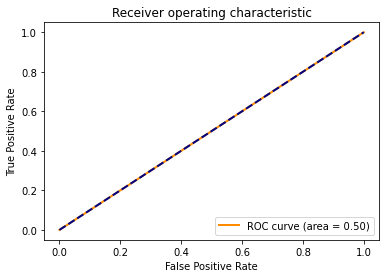

In [319]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [320]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9727534879776091

In [321]:
# compute confusion matrix
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[45877,     0],
       [ 1285,     0]])

In [322]:
# compute precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print("Precision: {0} \nRecall: {1} \nF1 Score: {2}".format(precision, recall, f1_score, _))

Precision: 0.9462493483726045 
Recall: 0.9727534879776091 
F1 Score: 0.9593183883736665


/Users/harrisonbarth/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


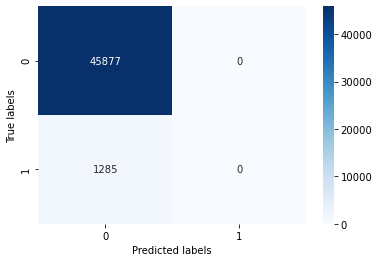

In [323]:
# create a heatmap of the confusion matrix
sb.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()